Big massive imports. Not happy with this global import, but Jeremy likes it and so all of the examples follow this style.

In [1]:
from fastcore.all import *
from fastai.vision.all import *

Set up the path and check the files.

All images: 97
Verification failed: 0


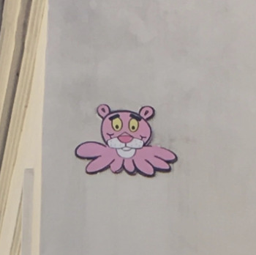

In [2]:
path = Path('/Users/przemek/projects/labs/street-art/training')
image_files = get_image_files(path)
failed = verify_images(image_files)
print(f'All images: {len(image_files)}')
print(f'Verification failed: {len(failed)}')

im = Image.open(get_image_files(path)[0])
im.to_thumb(256,256)

OK let's get to it. Preparing the data block.

env: PYTORCH_ENABLE_MPS_FALLBACK=1


/Users/przemek/projects/street-art/.env/lib/python3.11/site-packages/torch/_tensor.py:1386: UserWarning: The operator 'aten::_linalg_solve_ex.result' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  ret = func(*args, **kwargs)


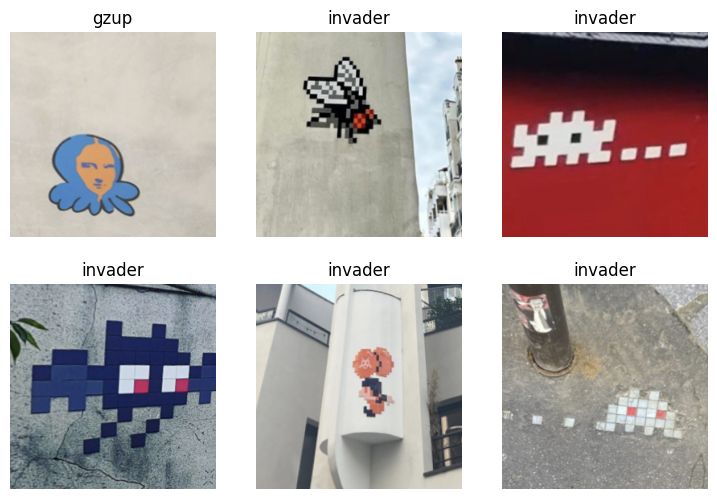

In [3]:
%env PYTORCH_ENABLE_MPS_FALLBACK=1

data_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=44),
    get_y=parent_label,
    item_tfms=[Resize(512, method='squish')]
)

data_block = data_block.new(item_tfms=RandomResizedCrop(256, min_scale=0.6), batch_tfms=aug_transforms())

dls = data_block.dataloaders(path, bs=6)
dls.show_batch(max_n=6)

Now let's fine tune the model

In [4]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
%time learn.fine_tune(7)

CPU times: user 23.2 s, sys: 2.14 s, total: 25.3 s
Wall time: 27.7 s


We can glean some insights from the learner

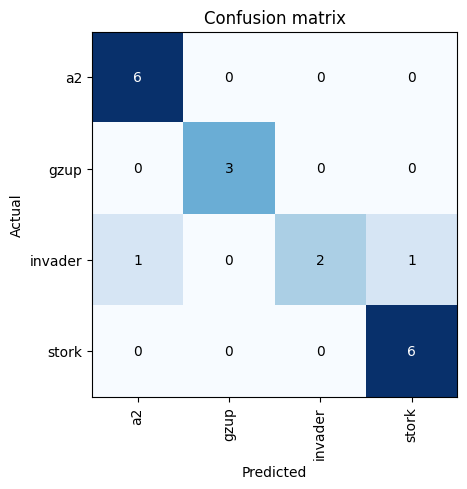

In [5]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

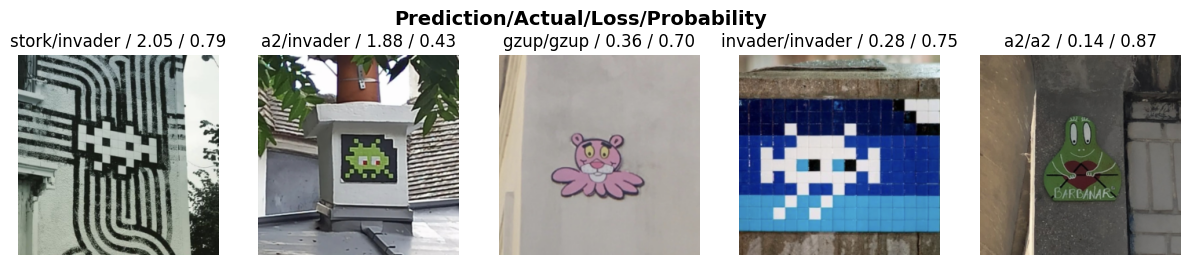

In [6]:
interp.plot_top_losses(5, nrows=1)

Now let's see how it does on test data (separate from training OFC)

This is: stork, confidence: 0.9942


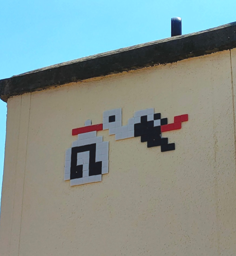

This is: a2, confidence: 0.9748


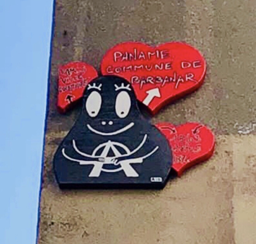

This is: a2, confidence: 0.8790


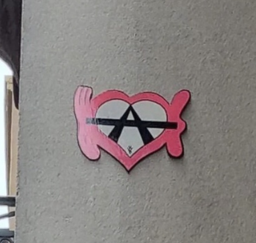

This is: gzup, confidence: 0.7000


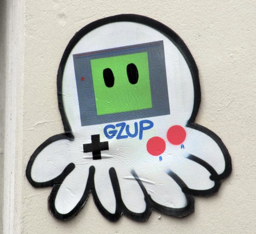

This is: stork, confidence: 0.9080


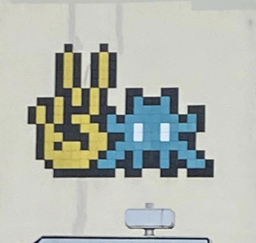

This is: invader, confidence: 0.6913


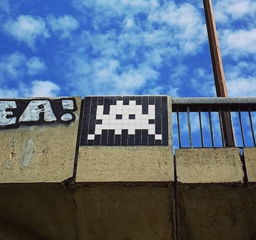

This is: stork, confidence: 0.9986


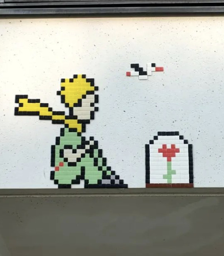

This is: gzup, confidence: 0.9394


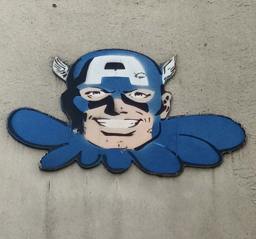

In [7]:
import IPython.display as display

test_path = Path('/Users/przemek/projects/labs/street-art/test')
test_files = get_image_files(test_path)
for test_file in test_files:
    label,index,probs = learn.predict(PILImage.create(test_file))
    print(f"This is: {label}, confidence: {probs[index]:.4f}")
    im = Image.open(test_file)
    display.display(im.to_thumb(256,256))

Ready to save the resulting model

In [8]:
learn.export('model.pkl')